In [49]:
%matplotlib inline

import numpy as np

import pandas as pd
from pandas_datareader import data

import matplotlib.pyplot as plt
import matplotlib.finance as mfinance
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.transforms as mtransforms

from statsmodels import stats
import scipy.optimize as opt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,LinearRegression

import theano
import theano.tensor as T

In [50]:
from_date = '2016-01-01'
to_date = '2016-03-01'
symbols = ['AAPL','GOOG','AMZN','FB','MSFT','SPY']
stocks = {}
for symbol in symbols:
    stocks[symbol] = data.DataReader(symbol,'yahoo',from_date,to_date)

In [53]:
class Order(object):
    def __init__(self):
        pass
    
class MarketOrder(Order):
    def __init__(self,symbol,amount):
        self._symbol = symbol
        self._amount = amount

class LimitOrder(Order):
    def __init__(self,symbol,price,amount):
        self._symbol = symbol
        self._price = price
        self._amount = amount
    
class Portfolio(object):
    def __init__(self):
        self._assets = {}
    def add_asset(self,symbol,amount):
        self._assets[symbol] = self._assets.get(symbol,0) + amount
    def remove_asset(self,symbol,amount):
        if symbol in self._assets and self._assets[symbol] >= amount:
            self._assets[symbol] -= amount
    def get_asset_amount(self,symbol):
        return self._assets.get(symbol,0)
    
class Context(object):
    def __init__(self,initial_cash):
        self._initial_cash = initial_cash
        self._available_cash = initial_cash
        self._total_cash_for_buying = 0.
        self._total_cash_for_selling = 0.
        self._portfolio = Portfolio()
        
class QSystem(object):
    
    def __init__(self,from_date,to_date,data,initial_cash,initialize=None,handle_data=None):
        self._data = data
        self._from_date = from_date
        self._to_date = to_date
        self._orders = []
        self._context = Context(initial_cash)
        self._context.order = self._order
        self._context.evaluation = self._evaluation
        self._current_date = None
        self._initialize = initialize
        self._handle_data = handle_data
        
    def run(self):
        _from = pd.Timestamp(self._from_date)
        _to = pd.Timestamp(self._to_date)
        _delta = pd.Timedelta(days=1)
        self._process_initialize(self._context)
        while _from != _to:
            self._current_date = _from
            print self._current_date
            _from += _delta
            _temp_data = {}
            for symbol in self._data:
                _temp_data[symbol] = self._data[symbol][:_from]
            self._process_handle_data(self._context,pd.Panel(_temp_data))
            self._process_order(_from)
    
    def _order(self,order):
        self._orders.append(order)
        
    def _process_initialize(self,context):
        if self._initialize is not None:
            self._initialize(context)
    
    def _process_handle_data(self,context,data):
        if self._handle_data is not None:
            self._handle_data(context,data)
    
    def _process_order(self,current_date):
        while len(self._orders) > 0:
            self._orders.reverse()
            order = self._orders.pop()
            buying_price = -1
            selling_price = -1
            if isinstance(order,MarketOrder):
                try:
                    open_price = self._data[order._symbol]['Open'][current_date]
                    if order._amount > 0:
                        buying_price = open_price
                        if buying_price != -1:
                            self._process_buying(order._symbol,buying_price,order._amount)
                    else:
                        selling_price = open_price
                        if selling_price != -1:
                            self._process_selling(order._symbol,selling_price,np.abs(order._amount))
                except KeyError:
                    print 'Not available date',current_date
            elif isinstance(order,LimitOrder):
                try:
                    high_price = self._data[order._symbol]['High'][current_date]
                    low_price = self._data[order._symbol]['Low'][current_date]           
                    if order._amount > 0:
                        if order._price >= low_price and order._price <= high_price:                                
                            buying_price = order._price
                        elif order._price > high_price:
                            buying_price = high_price
                        elif order._price < low_price:
                            print 'The order hasnt been made', order._price, '<' , low_price
                        if buying_price != -1:
                            self._process_buying(order._symbol,buying_price,order._amount)
                    else:
                        if order._price >= low_price and order._price <= high_price:                                
                            selling_price = order._price
                        elif order._price < low_price:
                            selling_price = low_price
                        elif order._price > high_price:
                            print 'The order hasnt been made', order._price, '>' , high_price
                        self._process_selling(order._symbol,selling_price,np.abs(order._amount))
                except KeyError:
                    print 'Not available date',current_date
            else:
                print 'none'
        
    def _process_buying(self,symbol,price,amount):
        print '_process_buying',symbol,price,amount
        if self._context._available_cash >= price * amount:
            self._context._portfolio.add_asset(symbol,amount)
            self._context._available_cash -= price * amount
            self._context._total_cash_for_buying += price * amount
        else:
            print 'Not enought cash to buy'
            
    def _process_selling(self,symbol,price,amount):
        print '_process_selling',symbol,price,amount
        if self._context._portfolio.get_asset_amount(symbol) >= amount:
            self._context._portfolio.remove_asset(symbol,amount)
            self._context._available_cash += price * amount
            self._context._total_cash_for_selling += price * amount
        else:
            print 'Not enought amount to sell'
        
    def _evaluation(self):
        print self._current_date
        try:
            portfolio_valuation = 0.
            for symbol in self._context._portfolio._assets: 
                print symbol,self._context._portfolio._assets[symbol],self._data[symbol]['Close'][self._current_date]
                portfolio_valuation += self._context._portfolio._assets[symbol] * self._data[symbol]['Close'][self._current_date]
            print self._context._available_cash + portfolio_valuation
        except KeyError:
            pass
        
#####################

class Stock(object):
    def __init__(self,symbol,data):
        self._symbol = symbol
        self._data = data
    def compute_alpha_beta(self,benchmark):
        ret = self._data['Close'].pct_change()[1:].values.reshape(-1,1)
        benchmart_ret = benchmark['Close'].pct_change()[1:].values.reshape(-1,1)
        reg = LinearRegression()
        reg.fit(X=benchmart_ret,y=ret)
        self._beta = reg.coef_[0,0]
        self._alpha = reg.intercept_[0]
    
class Strategy(object):
    def __init__(self):
        pass
    def isEnter(self,context,data):
        pass
    def isExit(self,context,data):
        pass
        
def initialize(context):
    pass

def handle_data(context,data):
    context.order(MarketOrder('AAPL',100))
    context.order(MarketOrder('AAPL',-50))
    context.evaluation()
    
q = QSystem(from_date,to_date,stocks,100000,initialize,handle_data)  
q.run()


2016-01-01 00:00:00
2016-01-01 00:00:00
100000.0
Not available date 2016-01-02 00:00:00
Not available date 2016-01-02 00:00:00
2016-01-02 00:00:00
2016-01-02 00:00:00
100000.0
Not available date 2016-01-03 00:00:00
Not available date 2016-01-03 00:00:00
2016-01-03 00:00:00
2016-01-03 00:00:00
100000.0
_process_buying AAPL 102.610001 100
_process_selling AAPL 102.610001 50
2016-01-04 00:00:00
2016-01-04 00:00:00
AAPL 50 105.349998
100136.99985
_process_buying AAPL 105.75 100
_process_selling AAPL 105.75 50
2016-01-05 00:00:00
2016-01-05 00:00:00
AAPL 100 102.709999
99852.99985
_process_buying AAPL 100.559998 100
_process_selling AAPL 100.559998 50
2016-01-06 00:00:00
2016-01-06 00:00:00
AAPL 150 100.699997
99658.9996
_process_buying AAPL 98.68 100
_process_selling AAPL 98.68 50
2016-01-07 00:00:00
2016-01-07 00:00:00
AAPL 200 96.449997
98909.99945
_process_buying AAPL 98.550003 100
_process_selling AAPL 98.550003 50
2016-01-08 00:00:00
2016-01-08 00:00:00
AAPL 250 96.959999
98932.49965


In [3]:
def show_chart(prices,indicators=None,moving_average=None,buying_history=None,selling_history=None):

    dates = [ mdates.date2num(date) for date in prices.index]
    open_prices = prices['Open']
    high_prices = prices['High']
    low_prices = prices['Low']
    close_prices = prices['Close']
    volumes = prices['Volume'] if 'Volume' in prices.columns else None

    chart_data = np.matrix([dates,open_prices,high_prices,low_prices,close_prices]).T.tolist()

    fig = plt.figure(figsize=(15,8))
    ax1 = plt.subplot2grid((5,4),(0,0),rowspan=4,colspan=4)
    mfinance.candlestick_ohlc(ax1,chart_data,colorup='r',colordown='b',alpha=0.7)
    ax1.grid(True)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('Price')
    
    ax2 = plt.subplot2grid((5,4),(4,0),sharex=ax1,rowspan=1,colspan=4)
    ax2.grid(True)

#     if buying_history is not None and len(buying_history) > 0:
#         dx, dy = -3/72., 0.
#         offset = mtransforms.ScaledTranslation(dx, dy,fig.dpi_scale_trans)
#         shadow_transform = ax1.transData + offset

#         buying_dates = [ mdates.date2num(date) for date in buying_history.index]
#         ax1.plot(buying_dates,buying_history.values,'r>',transform=shadow_transform)

#     if selling_history is not None and len(selling_history) > 0:
#         dx, dy = +3/72., 0.
#         offset = mtransforms.ScaledTranslation(dx, dy,fig.dpi_scale_trans)
#         shadow_transform = ax1.transData + offset

#         selling_dates = [ mdates.date2num(date) for date in selling_history.index]
#         ax1.plot(selling_dates,selling_history.values,'b<',transform=shadow_transform)

#     if moving_average is not None:
#         for w in moving_average:
#             ma = sma(close_prices,w)
#             ax1.plot(dates[-len(ma):],ma)

#     if indicators is not None and 'bollinger' in indicators:
#         middle,upper,lower = bollinger_bands(close_prices)
#         ax1.plot(dates[-len(middle):],middle)
#         ax1.plot(dates[-len(upper):],upper)
#         ax1.plot(dates[-len(lower):],lower)
#     if indicators is not None and 'macd' in indicators:
#         macd_line,macd_signal,macd_hist,ma_long,ma_short = macd(close_prices)
#         ax2.plot(dates[-len(macd_line):],macd_line)
#         ax2.plot(dates[-len(macd_signal):],macd_signal)
#         ax2.bar(dates[-len(macd_hist):],macd_hist)
#         ax2.axes.yaxis.set_ticklabels([])
#         plt.ylabel('MACD')
#     elif indicators is not None and 'rsi' in indicators:
#         r,s = rsi(close_prices)
#         ax2.plot(dates[-len(r):],r)
#         ax2.plot(dates[-len(s):],s)
#         plt.ylabel('RSI')
#     elif volumes is not None:
#         plt.ylabel('Volume')
#         ax2.bar(dates[-len(volumes):],volumes)
#         ax2.axes.yaxis.set_ticklabels([])

    fig.subplots_adjust(hspace=0)
    plt.setp( plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.setp(ax1.get_xticklabels(),visible=False)
    ax1.set_yticks(ax1.get_yticks()[1:])
    return ax1,ax2
#     plt.show()


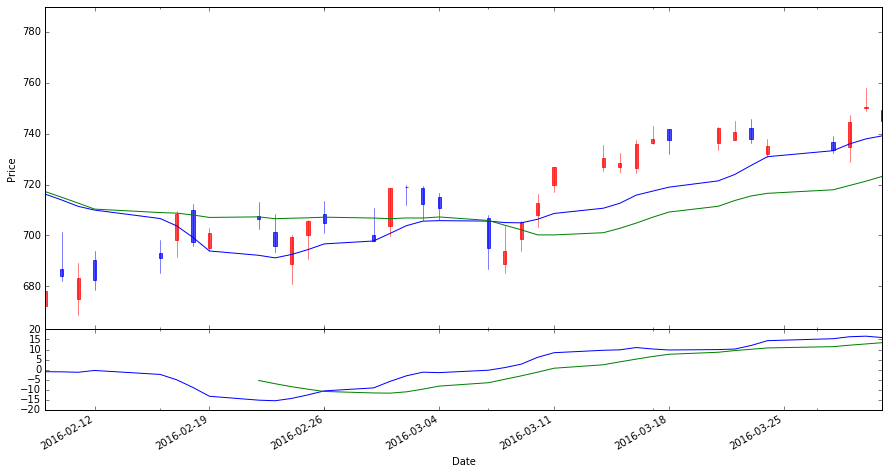

In [9]:
prices = goog_data['Close']
sma_short_window = 12
sma_long_window = 26
signal_window = 9
ma1 = pd.rolling_mean(goog_data['Close'],window=sma_short_window).dropna()
ma2 = pd.rolling_mean(goog_data['Close'],window=sma_long_window).dropna()

pd.ro

diff = (ma1 - ma2).dropna()
signal = pd.rolling_mean(diff,window=signal_window).dropna()

ax1,ax2 = show_chart(goog_data[goog_data.columns[:5]])
ma1.plot(ax=ax1)
ma2.plot(ax=ax1)

diff.plot(ax=ax2)
signal.plot(ax=ax2)

# (ma1 - ma2).dropna().plot(ax=ax2,kind='bar')